In [1]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import LabelEncoder
from sklearn.linear_model import LogisticRegression

from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.model_selection import train_test_split

# from sklearn.pipeline import Pipeline, FeatureUnion
# from sklearn.preprocessing import OneHotEncoder, StandardScaler

from sklearn.svm import SVC

import matplotlib.pyplot as plt

Получите данные и загрузите их в рабочую среду. (Jupyter Notebook или другую)

In [2]:
# читаем датасет
df = pd.read_csv( 'adult.csv' )
# все признаки
df.columns

Index(['age', 'workclass', 'fnlwgt', 'education', 'educational-num',
       'marital-status', 'occupation', 'relationship', 'race', 'gender',
       'capital-gain', 'capital-loss', 'hours-per-week', 'native-country',
       'income'],
      dtype='object')

Проведите первичный анализ.

In [3]:
# анализируемые признаки
used_cols = [
        'age', # гаусс, но обрезанный, только больше 12 лет где-то - https://prnt.sc/w82zxx  - можно попробовать нормировать
    'workclass', 
    # 'fnlwgt', # пока не трогаю, оценку ухудшает
    #  'education', # есть цифровой признак - этот не нужен - попробовал, ухудшает score
        'educational-num', # можно попробовать нормировать - есть центральные максимумы, хвост слева, но посередине дырка
       'marital-status', 
       'occupation', 
       'relationship', 
       'race', 
       'gender', # 
       'capital-gain', # распределение скорее пуассоновское 
      #  'capital-loss', # очень мало не 0 -  сильно (на 3%) ухудшает score. странно, может нужно с обратным знаком брать?
       'hours-per-week',
    #    'native-country', # интересно - ухудшает оценку
    #    'income' - целевой признак
       ]
# нечисловые признаки
cat_cols = ['gender', 'race', 'marital-status','occupation','relationship','education','workclass', 'native-country',
#  'capital-loss'
 ]


Проверьте данные на пропуски. Удалите в случае обнаружения. *Предложите альтернативный способ работы с пропусками.

Тут пропусков нет, но вообще пропуски можно заполнять:
* нулями, если это категориальный признак - потом такие строки будут выделены в отдельную колонку через one hot encoding и не помешают расчету
* если это вещественный признак - построить модель, которая предскажет значение этих колонок по остальным (кроме целевой) - сложно, вносит искажения в данные
* также для вещественного признака - взять среднее по выборке (или по какой-то подвыборке) - срендее между выбрасыванием и построением модели

In [10]:
# Пропусков нет.
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 48842 entries, 0 to 48841
Data columns (total 16 columns):
 #   Column           Non-Null Count  Dtype 
---  ------           --------------  ----- 
 0   age              48842 non-null  int64 
 1   workclass        48842 non-null  object
 2   fnlwgt           48842 non-null  int64 
 3   education        48842 non-null  object
 4   educational-num  48842 non-null  int64 
 5   marital-status   48842 non-null  object
 6   occupation       48842 non-null  object
 7   relationship     48842 non-null  object
 8   race             48842 non-null  object
 9   gender           48842 non-null  object
 10  capital-gain     48842 non-null  int64 
 11  capital-loss     48842 non-null  int64 
 12  hours-per-week   48842 non-null  int64 
 13  native-country   48842 non-null  object
 14  income           48842 non-null  object
 15  index1           48842 non-null  int64 
dtypes: int64(7), object(9)
memory usage: 6.0+ MB


Постройте 1-2 графика на выбор. Визуализация должна быть основана на исследуемых данных и быть полезной (из графика можно сделать вывод об особенностях датасета/класса/признака)

Посмотрим на колонку, значения которой предположительно нужно нормировать (до и после нормировки) - убедимся, что нормировка нужна и прошла корректно

array([[<AxesSubplot:title={'center':'hours-per-week'}>]], dtype=object)

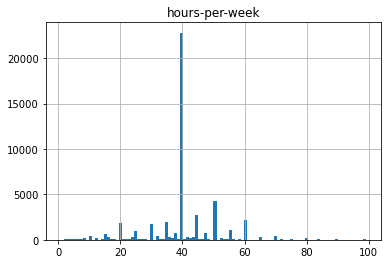

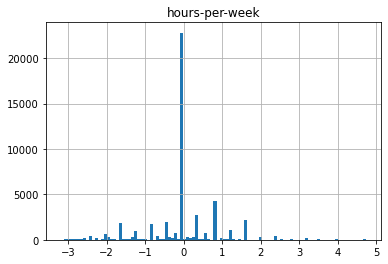

In [11]:

scaler = StandardScaler()

df['index1'] = df.index
cols_to_norm = ['age',
'educational-num',
 'hours-per-week',
 'capital-gain'
 ]
dff = df.copy()

df.hist(column='hours-per-week',bins=100) # before scaling
dff[cols_to_norm] = pd.DataFrame(scaler.fit_transform(df[cols_to_norm]),columns=cols_to_norm)
dff.hist(column='hours-per-week',bins=100) # after scaling

Преобразуйте категориальные признаки.

In [7]:

X = pd.get_dummies(dff[used_cols], columns=[c for c in cat_cols if c in used_cols])


C:\Users\Sergei\anaconda3\envs\uoit\lib\site-packages\sklearn\linear_model\_logistic.py:762: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


0.8539521032386153

Разделите выборку на обучающее и тестовое подмножество. 80% данных оставить на обучающее множество, 20% на тестовое.

In [ ]:

le = LabelEncoder()
le.fit( df['income'] )
# le.classes_
y = pd.Series( data = le.transform( df['income'] ) )

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=42)


Обучите модели **логистической регрессии** и опорных векторов на обучающем множестве.
Для тестового множества предскажите уровень дохода и сравните с истинным значением, посчитав точность предсказания моделей. Для этого используйте встроенную функцию score.

In [14]:

model = LogisticRegression(max_iter=1000)
model.fit( X_train, y_train )
# predictions = model.predict_proba( X_train )
# model.predict(X)
model.score(X_test, y_test)

0.8545725276088845

0.8545725276088845 - со стандартизацией величин, которые как-то похожи на стандартные  
0.8435910162551185 - просто за счет выбора колонок, без преобработки скейлерами

Обучите модели логистической регрессии и **опорных векторов** на обучающем множестве.
Для тестового множества предскажите уровень дохода и сравните с истинным значением, посчитав точность предсказания моделей. Для этого используйте встроенную функцию score.

In [12]:
model2 = SVC(kernel='rbf', degree=1, gamma='scale') 
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, train_size = 10000, random_state=42)

model2.fit(X_train, y_train)
model2.score(X_test,y_test)

0.8604045166894155

Выводы:
SVC (метод опортных векторов) более продвинутый метод и с ядрами (отличными от линейного) дает лучше результат.
Линейный классификатор не смотря на простоту при хорошей обработке данных не плохо справился с задачей. Он быстрее.

Эксперименты с разными шкалами и размерами обучающей выборки дали такие результаты:
0.8604045166894155 - с train_size = 10 000, kernel='rbf', gamma='scale' - лучше, чем у лин. регрессии  
0.8509120238242959 - с train_size = 10 000, kernel='poly', degree=1  
0.8451420771807917 - с train_size = 1 000, kernel='poly', degree=1  
0.8489266658394342 - с train_size = 10 000, kernel='linear'